# 0 - Setup

**Load required packages, including tensorflow, numpy, pandas, and some package for image processing. It is recommend to use GPU version of tensorflow**

In [1]:
# import section
import tensorflow as tf
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# test whether GPU version of tensorflow is running. Run the following command and look at the Anaconda Prompt window
# and you should be able to see Nvidia 

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

# 1 - Exploratory Analysis of the Data

**First, let's find out how many images are in the dataset, and what are the different breeds. The label data contains two columns. The "id" columns contains the image name of the jpg images, and the "breed" columns is the labels of the dog breed.**

In [3]:
label_data = pd.read_csv("labels.csv")
label_data.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


**And there are 10222 images in the dataset**

In [4]:
print (label_data.shape[0])


10222


**From the chart below, there are about 120 different dog breeds, and each dog breeds has roughtly 66 to 126 images**

In [5]:
A = pd.DataFrame(label_data["breed"].value_counts()).reset_index()  # group by and count by unique items in the 'Breed' column
A.columns = ["Breed", "Count"] #rename the column and display it in a nice format
A

,Breed,Count
0,scottish_deerhound,126
1,maltese_dog,117
2,afghan_hound,116
3,entlebucher,115
4,bernese_mountain_dog,114
5,shih-tzu,112
6,great_pyrenees,111
7,pomeranian,111
8,basenji,110
9,samoyed,109


**Then we look at the image to see if all the images are the same size or the same color scale**

**The function read_random_image() below will read some random images for a breed specified by user. If the user does not specified any breed, some random images will be shown**

In [6]:
def read_random_image (n_image = 1, breed = "not_specified", label_data = label_data, random_seed = 124):
    # this is a function for reading a random_image of a specific breed from the data set
    import random as rd
    import matplotlib.pylab as plt
    
    rd.seed(random_seed)
    
    for i in range(0, n_image):
        if breed == "not_specified":
            random_index =rd.randint(0, label_data.shape[0]-1)
            
            image = plt.imread('dogs/'+ label_data['id'][random_index]+".jpg")
            plt.figure()
            #print ('The breed is', label_data['breed'][random_index])
            #print ("The image shape is" , image.shape)
            plt.imshow(image)
            plt.title('The breed is ' + str(label_data['breed'][random_index]) + " and the image shape is " + str(image.shape))
            

        else:
            subset_id_list = label_data[label_data['breed'] == breed]
            random_index =rd.randint(0, subset_id_list.shape[0]-1) #must include -1 because of python's zero indexing
            
            image = plt.imread(('dogs/'+ subset_id_list['id'].iloc[random_index]+".jpg"))
            plt.figure()
            
            plt.imshow(image)
            plt.title('The breed is ' + str(breed) + " and the image shape is " + str(image.shape) )
            
    
        

**Let's take a look at a couple different breeds of dogs. 
Examine three random images of "Entlebucher" breed**

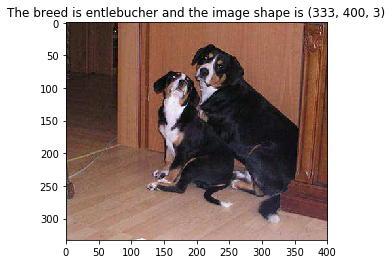

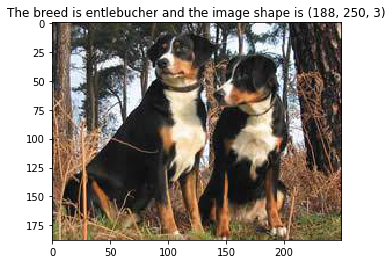

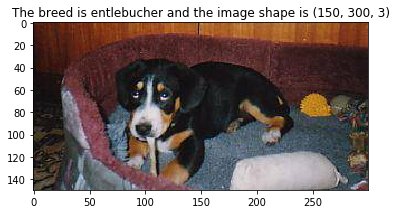

In [7]:
read_random_image(n_image = 3, breed = "entlebucher",random_seed = 124)

**Examine some images of "briard" breed**

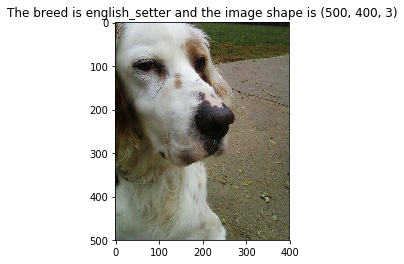

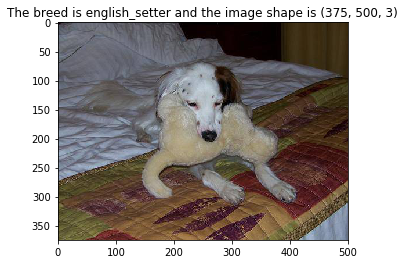

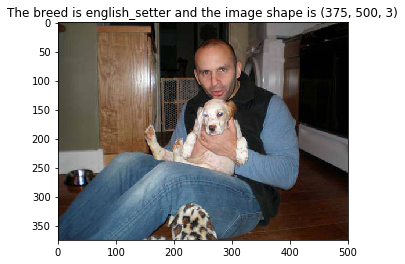

In [8]:
read_random_image(n_image = 3, breed = "english_setter", random_seed = 68)

**By examining some image of breeds using the above, we can see that the images are in different size, so resizing the images are necessary. It is also clear that the background is quite different for differnt images. Even for the same breed, there is some color difference for each individual dogs.**

**For some images, there are even multiple dogs, human, or cars in the images, which will act as "noise" in the input data; however, if the neural network can still classify the breeds with such noise, the model will be more robust in application.**

# 2 - Data Preparation

**2.1 Subsetting data**

**The subset_breeds function below will subset will allow users to specify the number of breeds to subset, and it will turn the subset of the dataframe containing only the selected breeds. Then train-test split will be performed on the selected dataframe**


In [9]:
def subset_breeds(MAX_BREEDS = 5, MAX_IMAGES = "Max", label_data = label_data, random_seed = 45):
    
    # This function will allow users to specify the number of breeds to subset, the maximum number of images of each breeds
    # and it will turn the subset of the dataframe containing only the selected breed
    
    # for now the MAX_IMAGES parameter is ignored
    import random as rd
    import numpy as np
    rd.seed(random_seed)
    
    total_dog_breeds = len((label_data["breed"]).unique())   #it will return 120
    random_breed_index = rd.sample(population = range(0, total_dog_breeds-1), k = MAX_BREEDS)  # generate some random integer without repeat
    breeds_selected = (label_data["breed"]).unique()[np.array(random_breed_index, dtype = int)] 
    # this is will return 1D numpy array with breeds'name  array(['toy_terrier', 'wire-haired_fox_terrier', 'bluetick',
       #'great_pyrenees'], dtype=object)
        
    #subset rows with selected breed
    data_subset= label_data[label_data["breed"].isin(breeds_selected )] # this will return a dataframe with selected breed
    data_subset.reset_index(drop=True)
    
    return (data_subset)

**The number of breeds for building model is specified below:**

**Set the MAX_BREEDS to 5 means we are using 5 breeds to build model**

In [10]:
MAX_BREEDS = 2
subset_breeds_DF = subset_breeds(MAX_BREEDS = MAX_BREEDS,random_seed = 856)
subset_breeds_DF.head(10)

print ("The following", MAX_BREEDS , "breeds are randomly selected to build the neural network:\n")
print (subset_breeds_DF["breed"].unique())

The following 2 breeds are randomly selected to build the neural network:

['english_setter' 'kerry_blue_terrier']


**2.2 Perform train-test split using Sklearn**

**The train_data and test_data contains subsets for rows from the original data frame corresponding to the breeds selected**

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

(train_data, test_data) = train_test_split(subset_breeds_DF , test_size=0.2, random_state=123)

In [12]:
train_image_id = list(train_data["id"]) # have to convert to list due to rusty numpy skills
train_label = np.array(train_data["breed"])   
test_image_id = list(test_data["id"])
test_label = np.array(test_data["breed"])

In [13]:
print (train_image_id [5])  # example output
print (train_label [5])
print (test_image_id [5])
print (test_label[5])


0a1f8334a9f583cac009dc033c681e47
kerry_blue_terrier
a68057c18b0977b5bedacbb3225a15f3
kerry_blue_terrier


**2.3 Data Preprocessing**

**This step include resizing all the selected image to the same size, and encoding label to numbers**

**Define helper functions:**

**The resize_image() is a helper function to resize an image to a user specified size**

In [14]:
def resize_image(image_file_name, width = 100, height = 100, show_image = False, show_dimension = False):

   # this function will resize the image
   # the parameter image_file_name should be in the format of "folder/XYZ.jpg"  
   # width will be the width you want to resize to
   # height will be the height you want to resize to
    
   # it will turn a three dimensional numpy array with dimension of (width, height, 3)

    from skimage.transform import resize
    image = plt.imread(image_file_name)
    resized_image = resize(image, (width, height), anti_aliasing=True)
    
    if show_image == True:
        plt.figure()
        plt.imshow(image)
        plt.title("Original image")
        
        plt.figure()
        plt.imshow(resized_image)
        plt.title("resized image")
        
    if show_dimension == True:
        print ("The dimension of the original image is ", image.shape)
        print ("The dimension of the resized image is ", resized_image.shape)
        
    
    return (resized_image.astype(np.float32)) #a three dimensional numpy array with dimension of (width, height, 3)

**Test the resize_image function using a single input**

The dimension of the original image is  (500, 500, 3)
The dimension of the resized image is  (100, 100, 3)


D:\Software\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


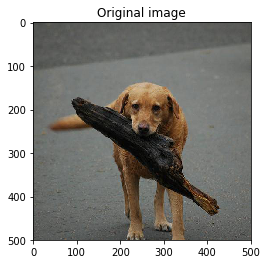

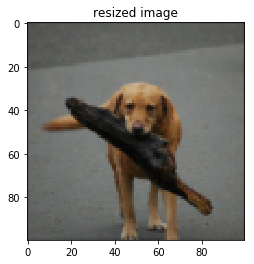

In [15]:
dummy_image_link = "dogs/0021f9ceb3235effd7fcde7f7538ed62.jpg"
dummy_image = plt.imread(dummy_image_link)

C = resize_image(dummy_image_link, 100, 100, show_image = True, show_dimension = True)

**The flip_image () is a helper function to flip an image, which will be used during data augmentation**

In [21]:
def flip_image (image, show_image = False):
    
   # this function will flip an image and left-right direction
   # the parameter image should be a iamge object
   # ig show_image = true, then the orignal image and the flipped image will be printed
    
   # it will turn a three dimensional numpy array with dimension of (width, height, 3)
    
    
    import numpy as np
    import matplotlib.pyplot as plt
 
    flipped_image = np.fliplr(image)  #numpy function for flipping image left-right
    
    if show_image == True:
        plt.figure()
        plt.imshow(image)
        plt.title("Original image")
        
        plt.figure()
        plt.imshow(flipped_image)
        plt.title("flipped image")
    
    return (flipped_image)

**Test the flip_image function using a single input**

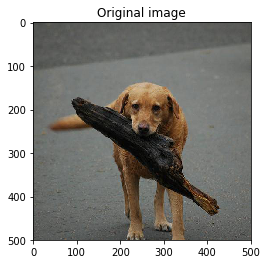

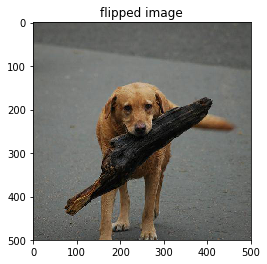

In [22]:
C = flip_image(dummy_image, show_image = True)

**The rotate_image () is a helper function to rotate an image by some random degree, which will be used during data augmentation**

In [23]:
def rotate_image (image, max_degree = 15, show_image = False, show_angle = False):
    #https://stackoverflow.com/questions/31401812/matplotlib-rotate-image-file-by-x-degrees
    
    # this function will flip an image and rotated by a +- certain degree randomly
   # the parameter image should be a image object
   # ig show_image = true, then the orignal image and the rotated image will be printed
    
   # it will turn a three dimensional numpy array with dimension of (width, height, 3)
    
    import random as rd
    import scipy.misc
    from scipy import ndimage
    import matplotlib.pyplot as plt
    #rd.sample(population = range(-20, 20), k = 1)[0]
    degree = rd.sample(population = range(-max_degree, max_degree), k = 1)[0]
    rotated_image = ndimage.rotate(image,  angle = degree,reshape = False )
                  
                  
    if show_angle == True:
        print ("The image has been rotated by ", degree, "degrees" )
        
    if show_image == True:
        plt.figure()
        plt.imshow(image)
        plt.title("Original image")
        
        plt.figure()
        plt.imshow(rotated_image)
        plt.title("Rotated image")

    
    return (rotated_image)

The image has been rotated by  14 degrees


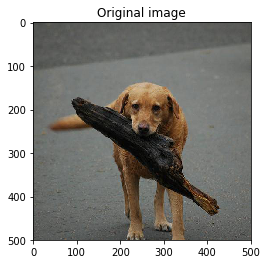

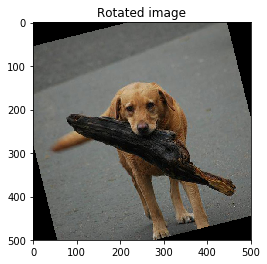

In [24]:

C = rotate_image(dummy_image, max_degree = 15,show_image = True, show_angle = True)


**The helper function image_preprocessing() will apply the resize_image function to every selected image**

In [25]:
def image_preprocessing(image_id_list, final_width = 200, final_height = 200):
    
    X_train_list = []
    
    for image_id in image_id_list:
        image_file_name = 'dogs/'+ image_id+".jpg"
        #print (image_file_name)
        resized_image = resize_image(image_file_name = image_file_name , width = final_width, height = final_height)
        
        X_train_list.append(resized_image)  #reszie the image
        
    
    return (np.array(X_train_list))
        

In [26]:
X_train = image_preprocessing(train_image_id)
X_test = image_preprocessing(test_image_id)

print (X_train.shape)
print (X_test.shape)

(132, 200, 200, 3)
(33, 200, 200, 3)


**The data_augmentation() function below will allow users to selected whether they want to augment data. If flip = True, flipped image will be added. If rotate = True, rotated images will be added as well**

**Data augentation will only be performed on the training dataset. The reason for this is we don't want the model to see any of the test data during training**

In [27]:
def data_augmentation (images_array, labels_array, flip = True, rotate = True):
    
    final_image_list = list(images_array)
    final_labels_list = list(labels_array)
    
    if (flip == False) and (rotate == False):
        return (images_array, labels_array)  # no change, return the original stuff
    
    
    
    elif (flip == True) and (rotate == True):
        for (image,image_label) in zip(list(images_array),list(labels_array)):
            
                flipped_image = flip_image(image)
                final_image_list.append(flipped_image)
                final_labels_list.append(image_label)
                
                rotated_image = rotate_image(image)
                final_image_list.append(rotated_image)
                final_labels_list.append(image_label)
    else:
        if flip == True:
            for (image,image_label) in zip(list(images_array),list(labels_array)):
                flipped_image = flip_image(image)
                final_image_list.append(flipped_image)
                final_labels_list.append(image_label)
                
        if rotate == True:
            for (image,image_label) in zip(list(images_array),list(labels_array)):
                rotated_image = rotate_image(image)
                final_image_list.append(rotated_image)
                final_labels_list.append(image_label)
        
    return (np.array(final_image_list), np.array(final_labels_list))


In [28]:
(X_train_final,train_label_final)= data_augmentation(X_train, train_label, flip = True,rotate = True) # added flipped data

In [29]:
print(X_train.shape) #before augmentation
print(X_train_final.shape) # after augmentation
print(train_label.shape)
print (train_label_final.shape)

(132, 200, 200, 3)
(396, 200, 200, 3)
(132,)
(396,)


**Encode the catagorical variables using sklearn LabelEncoder()**

In [30]:
def label_preprocessing(train_label,test_label):
    
    # encode the catagorical label to numeric so that tensorflow can accept it
    from sklearn import preprocessing
    
    le = preprocessing.LabelEncoder()
    le.fit(train_label)
    encoded_train_label = le.transform(train_label)
    encoded_test_label = le.transform(test_label)
    
    return (encoded_train_label,encoded_test_label)
    

In [31]:
(y_train, y_test) = label_preprocessing(train_label_final,test_label)

#this will return encoded labels

In [32]:
print (y_train)

[1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1
 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1
 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1
 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0
 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1
 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0
 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0
 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0
 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [33]:
print (y_test)

[0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0]


# 3. Training

In [ ]:
import gc
tf.keras.backend.clear_session() #destroy all existing graph
gc.collect()
#del model

**Belows shows a typical workflow of convolution networks build by Keras**

**3.1 setting up the network using keras**

In [ ]:
# from tensorflow import keras

conv_activation = "relu"
dense_activation = "sigmoid"

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta

# Parameters
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])  # width, height, color channel
MAX_BREEDS = len(np.unique(y_train))

# Build CNN

#Conv1
model = Sequential()
model.add(Conv2D(32, kernel_size = (7,7), strides=(1,1), activation='relu', input_shape=(input_shape),kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
# model.add(Dropout(0.33))

model.add(Conv2D(64, kernel_size = (7,7), activation=conv_activation,kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
# model.add(Dropout(0.33))

model.add(Conv2D(128, kernel_size = (5,5), activation=conv_activation,kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
# model.add(Dropout(0.33))

model.add(Conv2D(256, kernel_size = (5,5), activation=conv_activation,kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.50))

model.add(Flatten())
model.add(Dense(256, activation=dense_activation,kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))

model.add(Dense(16, activation=dense_activation,kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))

model.add(Dense(MAX_BREEDS, activation = 'softmax'))


#optimizer = Adadelta()
optimizer = Adam()
#tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

model.compile(optimizer=optimizer,
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

**3.2 Fit the model**

In [ ]:
model.fit(X_train_final, y_train, batch_size = 50, epochs = 10, verbose = 2,validation_data=(X_test,y_test))  # the function can perform validation for us
del model

**Wrapping all the stuff above in a single wrapper function for the ease of running and tuning. The code below is not meant to be readable.  The details of the network are in the later section of this cell**

In [6]:
def run(MAX_BREEDS,final_width = 200, final_height = 200, random_seed = 1234, \
        flip = True, rotate = True, conv_activation = "relu",\
       dense_activation = "sigmoid",kernel_initializer = "glorot_uniform"):
    
    # import section
    import tensorflow as tf
    import numpy as np
    import PIL.Image as Image
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    
    label_data = pd.read_csv("labels.csv")
    
    def resize_image(image_file_name, width = final_width, height = final_height, show_image = False, show_dimension = False):
        from skimage.transform import resize
        image = plt.imread(image_file_name)
        resized_image = resize(image, (width, height), anti_aliasing=True)
        if show_image == True:
            plt.figure()
            plt.imshow(image)
            plt.title("Original image")

            plt.figure()
            plt.imshow(resized_image)
            plt.title("resized image")
        if show_dimension == True:
            print ("The dimension of the resized image is ", resized_image.shape)
        return (resized_image.astype(np.float32)) #a three dimensional numpy array with dimension of (width, height, 3)
    
    def subset_breeds(MAX_BREEDS, MAX_IMAGES, label_data, random_seed):
        import random as rd
        import numpy as np
        rd.seed(random_seed)
        total_dog_breeds = len((label_data["breed"]).unique()) 
        random_breed_index = rd.sample(population = range(0, total_dog_breeds-1), k = MAX_BREEDS)  
        breeds_selected = (label_data["breed"]).unique()[np.array(random_breed_index, dtype = int)] 
        data_subset= label_data[label_data["breed"].isin(breeds_selected )] 
        return (data_subset)
    
    def flip_image (image, show_image = False):
        import numpy as np
        import matplotlib.pyplot as plt
        flipped_image = np.fliplr(image)  #numpy function for flipping image left-right
        return (flipped_image)
    def rotate_image (image, max_degree = 15, show_image = False, show_angle = False):
        import random as rd
        import scipy.misc
        from scipy import ndimage
        import matplotlib.pyplot as plt
        #rd.sample(population = range(-20, 20), k = 1)[0]
        degree = rd.sample(population = range(-max_degree, max_degree), k = 1)[0]
        rotated_image = ndimage.rotate(image,  angle = degree,reshape = False )
        return (rotated_image)
    
    def image_preprocessing(image_id_list, final_width = 200, final_height = 200):
        X_train_list = []

        for image_id in image_id_list:
            image_file_name = 'dogs/'+ image_id+".jpg"
            #print (image_file_name)
            resized_image = resize_image(image_file_name = image_file_name , width = final_width, height = final_height)

            X_train_list.append(resized_image)  #reszie the image
        return (np.array(X_train_list))
        
    def data_augmentation (images_array, labels_array, flip = True, rotate = True):
    
        final_image_list = list(images_array)
        final_labels_list = list(labels_array)

        if (flip == False) and (rotate == False):
            return (images_array, labels_array)  # no change, return the original stuff
        elif (flip == True) and (rotate == True):
            for (image,image_label) in zip(list(images_array),list(labels_array)):

                    flipped_image = flip_image(image)
                    final_image_list.append(flipped_image)
                    final_labels_list.append(image_label)

                    rotated_image = rotate_image(image)
                    final_image_list.append(rotated_image)
                    final_labels_list.append(image_label)
        else:
            if flip == True:
                for (image,image_label) in zip(list(images_array),list(labels_array)):
                    flipped_image = flip_image(image)
                    final_image_list.append(flipped_image)
                    final_labels_list.append(image_label)   
            if rotate == True:
                for (image,image_label) in zip(list(images_array),list(labels_array)):
                    rotated_image = rotate_image(image)
                    final_image_list.append(rotated_image)
                    final_labels_list.append(image_label)

        return (np.array(final_image_list), np.array(final_labels_list))
    
    def label_preprocessing(train_label,test_label):
        from sklearn import preprocessing
        le = preprocessing.LabelEncoder()
        le.fit(train_label)
        encoded_train_label = le.transform(train_label)
        encoded_test_label = le.transform(test_label)
        return (encoded_train_label,encoded_test_label)
    
    subset_breeds_DF = subset_breeds(MAX_BREEDS,random_seed,label_data = label_data, random_seed = random_seed)
    print ("The following", MAX_BREEDS , "breeds are randomly selected to build the neural network:")
    print (subset_breeds_DF["breed"].unique())
    (train_data, test_data) = train_test_split(subset_breeds_DF , test_size=0.3, random_state=random_seed)
    train_image_id = list(train_data["id"]) # have to convert to list due to rusty numpy skills
    train_label = np.array(train_data["breed"])   
    test_image_id = list(test_data["id"])
    test_label = np.array(test_data["breed"])
    X_train = image_preprocessing(train_image_id,final_width, final_height)
    X_test = image_preprocessing(test_image_id,final_width, final_height)
    
    print ("data augmentation condition:")
    if flip == True:
        print ("Flipped images are added to the dataset")
        
    if rotate == True:
        print ("Rotated images are added to the dataset")
    
    
    (X_train_final,train_label_final)= data_augmentation(X_train, train_label, flip = flip, rotate = rotate) # added flipped data
    (y_train, y_test) = label_preprocessing(train_label_final,test_label)
    
    
    
    import gc
    tf.keras.backend.clear_session() #destroy all existing graph
    gc.collect()
    
#################################################################################################
#################################################################################################
#################################################################################################
####################################Copy and Paste the network in here ##########################
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
    from tensorflow.keras import optimizers
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.optimizers import Adadelta
    from tensorflow.keras.callbacks import EarlyStopping

    # Parameters
    input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])  # width, height, color channel
    MAX_BREEDS = len(np.unique(y_train))
    print (input_shape)
    
    # Build CNN

    #Conv1
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (7,7), strides=(1,1), activation='relu', input_shape=(input_shape),\
                     kernel_initializer=kernel_initializer,kernel_regularizer = l2(0.005) ))
    model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
    model.add(BatchNormalization())
    
    

    
    model.add(Conv2D(64, kernel_size = (7,7), strides=(1,1), activation=conv_activation,\
                     kernel_initializer=kernel_initializer,kernel_regularizer = l2(0.005) ))
    model.add(MaxPooling2D(pool_size=(2,2), strides = (1,1)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, kernel_size = (5,5), strides=(1,1), activation=conv_activation,\
                     kernel_initializer=kernel_initializer,kernel_regularizer = l2(0.005) ))
    model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(196, kernel_size = (5,5), strides=(1,1), activation=conv_activation,\
                     kernel_initializer=kernel_initializer,kernel_regularizer = l2(0.005) ))
    model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    
    # model.add(Dropout(0.33))

    model.add(Flatten())
    model.add(Dense(156, activation=dense_activation,kernel_initializer=kernel_initializer,kernel_regularizer = l2(0.005)))
    model.add(Dropout(0.60))
    model.add(BatchNormalization())
    
    model.add(Dense(64, activation=dense_activation,kernel_initializer=kernel_initializer,kernel_regularizer = l2(0.005)))
    model.add(Dropout(0.60))
    model.add(BatchNormalization())
    
    model.add(Dense(MAX_BREEDS, activation = 'softmax'))


    #optimizer = Adadelta()
    optimizer = Adam()
    #tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

    model.compile(optimizer=optimizer,
                 loss = 'sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    
    #Early Stopping
    #callback = [EarlyStopping(monitor='val_loss', min_delta=0, patience=50, \
    #                                         verbose=1, mode='auto', baseline=None,restore_best_weights = True)]
    
#################################################################################################
#################################################################################################
#################################################################################################    
    
    
    model.fit(X_train_final, y_train, batch_size = 36, epochs = 400, \
              verbose = 2, validation_data=(X_test,y_test))  # the function can perform validation for us
    
    tf.keras.backend.clear_session() #destroy all existing graph
    gc.collect()
    del model

**Training a network for binary classification**

**Features to prevent overfitting include earlystopping, adding dropout, and l2 regularization. The network are built based on Alexnet (CaffeNet version) with many modification. Modification are needed because the Alexnet is have too many neurons and too many layers to be computed using a single GPU. The network consists of 4 convolution layers and two dense layers, and the optimizer is adam optimizer.**


**The results indicate that with the convolution network we build, after resizing the image to 100*100, adding data augmentaiton procedures such as rotating and flipping, and select sigmoid activation except for the 1st layer, we can get an accuracy of 83% to 89% accuracy for binary classificaiton of 'bedlington_terrier' and 'tibetan_mastiff' breeds.**


**Note: one can most of the parameter used in the ipython notebook, such as number of breeds, image size, seed, data augmentation, activation functions by changing the input argument in the run() function below**

In [2]:

binary = run(MAX_BREEDS = 2,    # number of breeds to play with
    final_width = 100, #resized image width
    final_height = 100,  #resized image height
    random_seed = 127,  #random seed to produce reproducible results
    flip = True,    #add flip image as augmentation
    rotate = True,  #add rotate image as augmentation
    conv_activation = "sigmoid",   #the activtion function for convolutional layers except for the 1st one
    dense_activation = "sigmoid",   #the activtion function for dense layers except for the output layers
    kernel_initializer = "glorot_normal"   #initialize for the weight, default is glorot_uniform
   )

The following 2 breeds are randomly selected to build the neural network:
['bedlington_terrier' 'tibetan_mastiff']


D:\Software\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


data augmentation condition:
Flipped images are added to the dataset
Rotated images are added to the dataset
(100, 100, 3)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 330 samples, validate on 48 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 4s - loss: 4.0211 - acc: 0.7242 - val_loss: 4.3081 - val_acc: 0.5833
Epoch 2/200
 - 1s - loss: 3.7714 - acc: 0.8242 - val_loss: 4.2304 - val_acc: 0.5833
Epoch 3/200
 - 1s - loss: 3.5012 - acc: 0.8424 - val_loss: 3.8781 - val_acc: 0.5833
Epoch 4/200
 - 1s - loss: 3.0951 - acc: 0.8879 - val_loss: 3.3045 - val_acc: 0.5833
Epoch 5/200
 - 1s - loss: 2.8111 - acc: 0.9000 - val_loss: 2.9143 - val_acc: 0.6250
Epoch 6/200
 - 1s - loss: 2.5153 - acc: 0.8848 - val_loss: 2.6268 - val_acc: 0.7500
Epoch 7/200
 - 1s - loss: 2.2750 - acc: 0.8909 - val_loss: 2.3100 - val_acc: 0.8333
Epoch 8/2

Epoch 85/200
 - 1s - loss: 0.5010 - acc: 0.9485 - val_loss: 0.9918 - val_acc: 0.8958
Epoch 86/200
 - 1s - loss: 0.5089 - acc: 0.9667 - val_loss: 2.4109 - val_acc: 0.4375
Epoch 87/200
 - 1s - loss: 0.5977 - acc: 0.9303 - val_loss: 1.4263 - val_acc: 0.7708
Epoch 88/200
 - 1s - loss: 0.6054 - acc: 0.9424 - val_loss: 1.5949 - val_acc: 0.6875
Epoch 89/200
 - 1s - loss: 0.6568 - acc: 0.9545 - val_loss: 1.2438 - val_acc: 0.8333
Epoch 90/200
 - 1s - loss: 0.6296 - acc: 0.9606 - val_loss: 1.1718 - val_acc: 0.7917
Epoch 91/200
 - 1s - loss: 0.6655 - acc: 0.9394 - val_loss: 1.3271 - val_acc: 0.7292
Epoch 92/200
 - 1s - loss: 0.5873 - acc: 0.9606 - val_loss: 1.9067 - val_acc: 0.6042
Epoch 93/200
 - 1s - loss: 0.6226 - acc: 0.9455 - val_loss: 1.1103 - val_acc: 0.8333
Epoch 94/200
 - 1s - loss: 0.5709 - acc: 0.9758 - val_loss: 1.1705 - val_acc: 0.8125
Epoch 95/200
 - 1s - loss: 0.5015 - acc: 0.9818 - val_loss: 1.2581 - val_acc: 0.7708
Epoch 96/200
 - 1s - loss: 0.4929 - acc: 0.9758 - val_loss: 1.165

**For 10 class classifcation, the performance with much more lower even though data augmentation is performed. The validation accuracy is about 30% to 35%, which is about 2 times better than a coin toss. The high training accuracy and low validation accuracy indicates that the model is still severaly overfitting the training data set**

**possible reasons for such poor performance may be due to noise in the images. There are also many images with multiple dogs, lousy background, and some even have human insde. The amount of data for each breed is also small (maximum is 120 images)**

In [7]:
ten_class = run(MAX_BREEDS = 10,    # number of breeds to play with
    final_width = 100, #resized image width
    final_height = 100,  #resied image height
    random_seed = 127,  #random seed to produce reproducible results
    flip = True,    #add flip image as augmentation
    rotate = True,  #add rotate image as augmentation
    conv_activation = "elu",  #the activtion function for convolutional layers except for the 1st one
    dense_activation = "sigmoid", #the activtion function for dense layers except for the output layers
    kernel_initializer = "glorot_normal" #initialize for the weight, default is glorot_uniform
   )

The following 10 breeds are randomly selected to build the neural network:
['bluetick' 'bedlington_terrier' 'norfolk_terrier' 'labrador_retriever'
 'tibetan_terrier' 'clumber' 'afghan_hound' 'irish_wolfhound' 'pomeranian'
 'tibetan_mastiff']
data augmentation condition:
Flipped images are added to the dataset
Rotated images are added to the dataset
(100, 100, 3)
Train on 1941 samples, validate on 278 samples
Epoch 1/400
 - 6s - loss: 6.0245 - acc: 0.1133 - val_loss: 5.1186 - val_acc: 0.1763
Epoch 2/400
 - 5s - loss: 4.9389 - acc: 0.1406 - val_loss: 4.1380 - val_acc: 0.1978
Epoch 3/400
 - 5s - loss: 4.0346 - acc: 0.1690 - val_loss: 3.6247 - val_acc: 0.1655
Epoch 4/400
 - 5s - loss: 3.5388 - acc: 0.1788 - val_loss: 3.2433 - val_acc: 0.2086
Epoch 5/400
 - 5s - loss: 3.2160 - acc: 0.1917 - val_loss: 3.0577 - val_acc: 0.1978
Epoch 6/400
 - 5s - loss: 3.0521 - acc: 0.1824 - val_loss: 2.7996 - val_acc: 0.2698
Epoch 7/400
 - 5s - loss: 2.8779 - acc: 0.2159 - val_loss: 2.7473 - val_acc: 0.2698


Epoch 93/400
 - 5s - loss: 2.5893 - acc: 0.4802 - val_loss: 3.6819 - val_acc: 0.1906
Epoch 94/400
 - 5s - loss: 2.5768 - acc: 0.4930 - val_loss: 3.3225 - val_acc: 0.2806
Epoch 95/400
 - 5s - loss: 2.5263 - acc: 0.5028 - val_loss: 3.4917 - val_acc: 0.3058
Epoch 96/400
 - 5s - loss: 2.5670 - acc: 0.5080 - val_loss: 3.7996 - val_acc: 0.2770
Epoch 97/400
 - 5s - loss: 2.4867 - acc: 0.5224 - val_loss: 4.2748 - val_acc: 0.2122
Epoch 98/400
 - 5s - loss: 2.4518 - acc: 0.5147 - val_loss: 3.6476 - val_acc: 0.2338
Epoch 99/400
 - 5s - loss: 2.4897 - acc: 0.5255 - val_loss: 4.5386 - val_acc: 0.1978
Epoch 100/400
 - 5s - loss: 2.5975 - acc: 0.5070 - val_loss: 3.9359 - val_acc: 0.2446
Epoch 101/400
 - 5s - loss: 2.6015 - acc: 0.5281 - val_loss: 4.1689 - val_acc: 0.2554
Epoch 102/400
 - 5s - loss: 2.5479 - acc: 0.5276 - val_loss: 4.0877 - val_acc: 0.2158
Epoch 103/400
 - 5s - loss: 2.5389 - acc: 0.5410 - val_loss: 3.9218 - val_acc: 0.2590
Epoch 104/400
 - 5s - loss: 2.5234 - acc: 0.5260 - val_loss: 

Epoch 189/400
 - 5s - loss: 1.9342 - acc: 0.8439 - val_loss: 6.2362 - val_acc: 0.2518
Epoch 190/400
 - 5s - loss: 1.8872 - acc: 0.8454 - val_loss: 5.6620 - val_acc: 0.2590
Epoch 191/400
 - 5s - loss: 1.9104 - acc: 0.8279 - val_loss: 5.6103 - val_acc: 0.2914
Epoch 192/400
 - 5s - loss: 1.8386 - acc: 0.8521 - val_loss: 5.3298 - val_acc: 0.2878
Epoch 193/400
 - 5s - loss: 1.8059 - acc: 0.8480 - val_loss: 5.7749 - val_acc: 0.3058
Epoch 194/400
 - 5s - loss: 1.8307 - acc: 0.8331 - val_loss: 6.8984 - val_acc: 0.2194
Epoch 195/400
 - 5s - loss: 1.9853 - acc: 0.8140 - val_loss: 6.3950 - val_acc: 0.2806
Epoch 196/400
 - 5s - loss: 1.9782 - acc: 0.8351 - val_loss: 5.3552 - val_acc: 0.2986
Epoch 197/400
 - 5s - loss: 1.8898 - acc: 0.8594 - val_loss: 6.3660 - val_acc: 0.2806
Epoch 198/400
 - 5s - loss: 1.8381 - acc: 0.8563 - val_loss: 5.6098 - val_acc: 0.2842
Epoch 199/400
 - 5s - loss: 1.9582 - acc: 0.8217 - val_loss: 6.0211 - val_acc: 0.2698
Epoch 200/400
 - 5s - loss: 2.0058 - acc: 0.8264 - val

Epoch 285/400
 - 5s - loss: 1.7739 - acc: 0.8764 - val_loss: 5.1786 - val_acc: 0.3165
Epoch 286/400
 - 5s - loss: 1.7083 - acc: 0.8872 - val_loss: 5.8047 - val_acc: 0.3345
Epoch 287/400
 - 5s - loss: 1.7328 - acc: 0.8722 - val_loss: 6.5115 - val_acc: 0.3022
Epoch 288/400
 - 5s - loss: 1.6752 - acc: 0.8846 - val_loss: 6.3186 - val_acc: 0.2590
Epoch 289/400
 - 5s - loss: 1.7775 - acc: 0.8568 - val_loss: 5.9890 - val_acc: 0.2878
Epoch 290/400
 - 5s - loss: 1.8087 - acc: 0.8552 - val_loss: 6.0554 - val_acc: 0.3094
Epoch 291/400
 - 5s - loss: 1.8709 - acc: 0.8563 - val_loss: 5.8621 - val_acc: 0.3094
Epoch 292/400
 - 5s - loss: 1.9384 - acc: 0.8557 - val_loss: 6.2186 - val_acc: 0.2770
Epoch 293/400
 - 5s - loss: 1.9729 - acc: 0.8516 - val_loss: 6.0760 - val_acc: 0.2878
Epoch 294/400
 - 5s - loss: 1.9092 - acc: 0.8660 - val_loss: 7.0501 - val_acc: 0.3129
Epoch 295/400
 - 5s - loss: 1.8000 - acc: 0.8815 - val_loss: 6.7662 - val_acc: 0.2662
Epoch 296/400
 - 5s - loss: 1.8293 - acc: 0.8666 - val

Epoch 381/400
 - 5s - loss: 1.7975 - acc: 0.8825 - val_loss: 5.6788 - val_acc: 0.3201
Epoch 382/400
 - 5s - loss: 1.7313 - acc: 0.8980 - val_loss: 5.4800 - val_acc: 0.3633
Epoch 383/400
 - 5s - loss: 1.6537 - acc: 0.9083 - val_loss: 6.5569 - val_acc: 0.3489
Epoch 384/400
 - 5s - loss: 1.6499 - acc: 0.8959 - val_loss: 6.0458 - val_acc: 0.3129
Epoch 385/400
 - 5s - loss: 1.7839 - acc: 0.8681 - val_loss: 5.6394 - val_acc: 0.3273
Epoch 386/400
 - 5s - loss: 1.7756 - acc: 0.8779 - val_loss: 6.3072 - val_acc: 0.3094
Epoch 387/400
 - 5s - loss: 1.7292 - acc: 0.8939 - val_loss: 5.3944 - val_acc: 0.3094
Epoch 388/400
 - 5s - loss: 1.7118 - acc: 0.8923 - val_loss: 5.9626 - val_acc: 0.2986
Epoch 389/400
 - 5s - loss: 1.7380 - acc: 0.8805 - val_loss: 5.8152 - val_acc: 0.3597
Epoch 390/400
 - 5s - loss: 1.6672 - acc: 0.8980 - val_loss: 5.4919 - val_acc: 0.3309
Epoch 391/400
 - 5s - loss: 1.7072 - acc: 0.8836 - val_loss: 5.8218 - val_acc: 0.3633
Epoch 392/400
 - 5s - loss: 1.7097 - acc: 0.8861 - val

**Try using Sigmoid activation function for all layers (it was not any better)**

In [ ]:
ten_class_2 = run(MAX_BREEDS = 10,    # number of breeds to play with
    final_width = 100, #resized image width
    final_height = 100,  #resied image height
    random_seed = 127,  #random seed to produce reproducible results
    flip = True,    #add flip image as augmentation
    rotate = True,  #add rotate image as augmentation
    conv_activation = "sigmoid",  #the activtion function for convolutional layers except for the 1st one
    dense_activation = "sigmoid", #the activtion function for dense layers except for the output layers
    kernel_initializer = "glorot_normal" #initialize for the weight, default is glorot_uniform
   )

The following 10 breeds are randomly selected to build the neural network:
['bluetick' 'bedlington_terrier' 'norfolk_terrier' 'labrador_retriever'
 'tibetan_terrier' 'clumber' 'afghan_hound' 'irish_wolfhound' 'pomeranian'
 'tibetan_mastiff']
data augmentation condition:
Flipped images are added to the dataset
Rotated images are added to the dataset
(100, 100, 3)
Train on 1941 samples, validate on 278 samples
Epoch 1/400
 - 6s - loss: 6.1121 - acc: 0.1242 - val_loss: 5.4546 - val_acc: 0.0863
Epoch 2/400
 - 5s - loss: 5.0399 - acc: 0.1566 - val_loss: 4.5419 - val_acc: 0.1043
Epoch 3/400
 - 5s - loss: 4.1655 - acc: 0.1638 - val_loss: 3.7887 - val_acc: 0.1331
Epoch 4/400
 - 5s - loss: 3.5985 - acc: 0.1886 - val_loss: 3.2523 - val_acc: 0.1978
Epoch 5/400
 - 5s - loss: 3.2897 - acc: 0.1777 - val_loss: 2.9338 - val_acc: 0.2266
Epoch 6/400
 - 5s - loss: 3.0894 - acc: 0.1942 - val_loss: 3.2865 - val_acc: 0.1403
Epoch 7/400
 - 5s - loss: 2.9540 - acc: 0.1850 - val_loss: 3.1666 - val_acc: 0.0935


Epoch 93/400
 - 5s - loss: 2.5595 - acc: 0.2494 - val_loss: 2.7751 - val_acc: 0.2014
Epoch 94/400
 - 5s - loss: 2.5734 - acc: 0.2540 - val_loss: 2.7044 - val_acc: 0.2194
Epoch 95/400
 - 5s - loss: 2.5984 - acc: 0.2545 - val_loss: 2.6184 - val_acc: 0.2770
Epoch 96/400
 - 5s - loss: 2.5288 - acc: 0.2669 - val_loss: 2.5820 - val_acc: 0.2446
Epoch 97/400
 - 5s - loss: 2.5768 - acc: 0.2468 - val_loss: 2.6812 - val_acc: 0.2662
Epoch 98/400
 - 5s - loss: 2.5437 - acc: 0.2561 - val_loss: 2.5308 - val_acc: 0.3165
Epoch 99/400
 - 5s - loss: 2.5018 - acc: 0.2679 - val_loss: 3.0169 - val_acc: 0.1295
Epoch 100/400
 - 5s - loss: 2.5052 - acc: 0.2638 - val_loss: 2.6594 - val_acc: 0.2302
Epoch 101/400
 - 5s - loss: 2.5622 - acc: 0.2519 - val_loss: 2.7217 - val_acc: 0.2662
Epoch 102/400
 - 5s - loss: 2.5568 - acc: 0.2628 - val_loss: 2.9973 - val_acc: 0.1403
Epoch 103/400
 - 5s - loss: 2.5417 - acc: 0.2591 - val_loss: 2.7911 - val_acc: 0.1978
Epoch 104/400
 - 5s - loss: 2.5034 - acc: 0.2653 - val_loss: 

Epoch 189/400
 - 5s - loss: 2.5045 - acc: 0.5647 - val_loss: 3.9919 - val_acc: 0.2590
Epoch 190/400
 - 5s - loss: 2.5639 - acc: 0.5616 - val_loss: 3.8917 - val_acc: 0.2338
Epoch 191/400
 - 5s - loss: 2.5372 - acc: 0.5585 - val_loss: 4.1975 - val_acc: 0.2410
Epoch 192/400
 - 5s - loss: 2.5845 - acc: 0.5523 - val_loss: 3.8827 - val_acc: 0.2914
Epoch 193/400
 - 5s - loss: 2.4808 - acc: 0.5920 - val_loss: 3.8134 - val_acc: 0.3201
Epoch 194/400
 - 5s - loss: 2.4731 - acc: 0.5956 - val_loss: 3.8607 - val_acc: 0.2698
Epoch 195/400
 - 5s - loss: 2.4857 - acc: 0.5956 - val_loss: 3.7131 - val_acc: 0.2518
Epoch 196/400
 - 5s - loss: 2.5257 - acc: 0.5662 - val_loss: 4.2028 - val_acc: 0.3058
Epoch 197/400
 - 5s - loss: 2.5121 - acc: 0.6090 - val_loss: 4.1301 - val_acc: 0.2554
Epoch 198/400
 - 5s - loss: 2.4199 - acc: 0.6260 - val_loss: 3.9547 - val_acc: 0.2554
Epoch 199/400
 - 5s - loss: 2.3673 - acc: 0.6291 - val_loss: 3.7677 - val_acc: 0.2698
Epoch 200/400
 - 5s - loss: 2.3854 - acc: 0.6327 - val

Epoch 285/400
 - 5s - loss: 2.0560 - acc: 0.8372 - val_loss: 4.9586 - val_acc: 0.2842
Epoch 286/400
 - 5s - loss: 2.0953 - acc: 0.8176 - val_loss: 5.2582 - val_acc: 0.3201
Epoch 287/400
 - 5s - loss: 2.0419 - acc: 0.8362 - val_loss: 5.1809 - val_acc: 0.3165
Epoch 288/400
 - 5s - loss: 2.0734 - acc: 0.8042 - val_loss: 5.3227 - val_acc: 0.3058
Epoch 289/400
 - 5s - loss: 2.1453 - acc: 0.7960 - val_loss: 5.1260 - val_acc: 0.3165
Epoch 290/400
 - 5s - loss: 2.1499 - acc: 0.8089 - val_loss: 5.1092 - val_acc: 0.3237
Epoch 291/400
 - 5s - loss: 2.1191 - acc: 0.8233 - val_loss: 5.0415 - val_acc: 0.3165
Epoch 292/400
 - 5s - loss: 2.1000 - acc: 0.8253 - val_loss: 5.4468 - val_acc: 0.3237
Epoch 293/400
 - 5s - loss: 2.0796 - acc: 0.8269 - val_loss: 5.2303 - val_acc: 0.2698
Epoch 294/400
 - 5s - loss: 2.0594 - acc: 0.8145 - val_loss: 5.1003 - val_acc: 0.3273
Epoch 295/400
 - 5s - loss: 2.0276 - acc: 0.8305 - val_loss: 5.5222 - val_acc: 0.3022
Epoch 296/400
 - 5s - loss: 2.0626 - acc: 0.8217 - val